# Text classification improving via GAN

**colab-to-git setting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
GIT_USERNAME = 'VirtualRoyalty'
GIT_REPOSITORY = 'gan-text-classification'

In [ ]:
%cd /content/drive/MyDrive/course-paper-2021/gan-text-classification
# !git init .
# !git remote add origin https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git

In [ ]:
GIT_BRANCH =  'main' #' feature/neptune' # 'feature/non-adversariality' #'feature/gan_trainer'
!git branch
!git checkout {GIT_BRANCH}
!git pull origin {GIT_BRANCH}
!git status
print('**OK**')

In [ ]:
%%capture
from IPython.display import clear_output
!pip install neptune-client
!pip install -r requirements.txt
clear_output(wait=True)
# !pip freeze | grep transformers

In [ ]:
# !pip install neptune-client
import os
import gc
import sys
import json
import numpy as np
import pandas as pd
import importlib as imp
import neptune.new as neptune
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn.functional as F
warnings.simplefilter('ignore')
sys.path.append('..')
# sys.path.append('gan-text-classification')
secret = json.load(open('neptune_token.json'))

# Data Loading

In [ ]:
import data_loader
data_loader = imp.reload(data_loader)

DATASET_NAME = 'qc' # '20ng', 'qc', 'sst', 'goemotions'
train_path = f"../data/{DATASET_NAME}/train.csv"
test_path = f"../data/{DATASET_NAME}/test.csv"


if DATASET_NAME == 'qc':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
elif DATASET_NAME == '20ng':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['clean_text', 'label_name']]
    train_df = train_df.rename(columns={'label_name': 'label', 'clean_text': 'text'})
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label_name']]
    test_df = test_df.rename(columns={'label_name': 'label', 'clean_text': 'text'})
elif DATASET_NAME == 'sst':
    train_df = pd.read_csv(train_path, encoding='utf-8', sep='\t', header=None, names=['label', 'text'])[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8', sep='\t', header=None, names=['label', 'text'])[['text', 'label']]
elif DATASET_NAME == 'goemotions':
    labels = open(f'../data/{DATASET_NAME}/labels.txt', 'r').read().split('\n')
    train_df = pd.read_csv(train_path, sep=',', encoding='utf-8')[['text', 'label']]
    # train_df = train_df.label.apply(lambda x: labels[int(x)])
    test_df = pd.read_csv(test_path, sep=',', encoding='utf-8')[['text', 'label']]
    # test_df = test_df.label.apply(lambda x: labels[int(x)])

print(f'Original train size: {len(train_df)}')
print(f'Original test size: {len(test_df)}')
print(f'Num of labels (train): {train_df.label.nunique()}')
print(f'Num of labels (test): {test_df.label.nunique()}')
print(f'\nNum of words (train) stats:')
train_df.text.str.split().apply(len).describe()

# Split to labeled and unlabeled

In [ ]:
from sklearn.model_selection import train_test_split

SAMPLES_PER_LABEL = 10
# PROPORTION = 0.2
PROPORTION = (train_df.label.nunique() * SAMPLES_PER_LABEL) / len(train_df)
print(PROPORTION)
# UNLABEL_PROPORTION = 1.0
UNLABEL_SIZE = 5000
UNLABEL_PROPORTION = (UNLABEL_SIZE) / len(train_df)
print(UNLABEL_PROPORTION)

UNKNOWN_LABEL_NAME = "UNK"

labeled_df, unlabeled_df, _, _ = train_test_split(train_df, train_df, test_size=(1-PROPORTION), 
                                                  random_state=30, stratify=train_df.label)
unlabeled_df = unlabeled_df.sample(frac=UNLABEL_PROPORTION)
unlabeled_df['label'] = UNKNOWN_LABEL_NAME
print(f"Labeled: {len(labeled_df)} Unlabeled: {len(unlabeled_df)}")

label_list = [UNKNOWN_LABEL_NAME] + train_df.label.unique().tolist()
label2id = {label:_id for _id, label in enumerate(label_list)}
_label2id = {label:_id for _id, label in enumerate(train_df.label.unique().tolist())}
print(f"Label count: {len(label_list)}")

## Experiment

In [ ]:
model_name = "bert-base-cased"
# model_name = 'distilbert-base-uncased'
# model_name = "bert-base-uncased"
# model_name = "roberta-base"
# model_name = "albert-base-v2"

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoConfig

transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
CONFIG = dict(model_name=model_name,
              frozen_backbone=False,
              batch_size=64,
              max_seq_length=64,
              num_hidden_layers_g=1,
              num_hidden_layers_d=1,
              noise_size=100,
              out_dropout_rate=0.2,
              apply_balance=True,
              num_labels=len(label_list),
              labeled_proportion=PROPORTION,
              unlabeled_proportion=UNLABEL_PROPORTION,
              labeled_df=len(labeled_df),
              unlabeled_df=len(unlabeled_df),
              learning_rate_discriminator=5e-5,
              learning_rate_generator=5e-5,
              epsilon=1e-8,
              num_train_epochs=5,
              multi_gpu=False,
              apply_scheduler=True,
              warmup_proportion_d=0.1,
              warmup_proportion_g=0.0,
              print_each_n_step=10,
              dataset=DATASET_NAME)

In [ ]:
train_examples = labeled_df.values.tolist()
CONFIG['num_train_examples'] = len(train_examples)
unlabeled_examples = unlabeled_df.values.tolist()
test_examples = test_df.values.tolist()

train_label_masks = np.ones(len(labeled_df), dtype=bool)
_train_dataloader = data_loader.generate_data_loader(train_examples, 
                                                     train_label_masks, 
                                                     label_map=_label2id, 
                                                     batch_size=CONFIG['batch_size'], 
                                                     tokenizer=tokenizer, 
                                                     max_seq_length=CONFIG['max_seq_length'],
                                                     do_shuffle=True, 
                                                     balance_label_examples=CONFIG['apply_balance'])

test_label_masks = np.ones(len(test_examples), dtype=bool)
_test_dataloader = data_loader.generate_data_loader(test_examples, 
                                                    test_label_masks, 
                                                    label_map=_label2id, 
                                                   batch_size=CONFIG['batch_size'], tokenizer=tokenizer,  
                                                   max_seq_length=CONFIG['max_seq_length'], 
                                                   do_shuffle=False, balance_label_examples=False)
if len(unlabeled_examples) > 0:
  labeled_examples = train_examples.copy()
  labeled_masks = train_label_masks.copy()
  train_examples = train_examples + unlabeled_examples
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks, tmp_masks])


labeled_dataloader = data_loader.generate_data_loader(labeled_examples, 
                                                    labeled_masks, 
                                                    label_map=label2id, 
                                                    batch_size=CONFIG['batch_size'], 
                                                    tokenizer=tokenizer, 
                                                    max_seq_length=CONFIG['max_seq_length'],
                                                    do_shuffle=True, 
                                                    balance_label_examples=CONFIG['apply_balance'])

train_dataloader = data_loader.generate_data_loader(train_examples, 
                                                    train_label_masks, 
                                                    label_map=label2id, 
                                                    batch_size=CONFIG['batch_size'], 
                                                    tokenizer=tokenizer, 
                                                    max_seq_length=CONFIG['max_seq_length'],
                                                    do_shuffle=True, 
                                                    balance_label_examples=CONFIG['apply_balance'])


test_dataloader = data_loader.generate_data_loader(test_examples, test_label_masks, label_map=label2id, 
                                                   batch_size=CONFIG['batch_size'], tokenizer=tokenizer,  
                                                   max_seq_length=CONFIG['max_seq_length'], 
                                                   do_shuffle=False, balance_label_examples=False)

# Preprocessing

# Model training



In [ ]:
import torch
import torch.nn.functional as F

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
print(torch.cuda.memory_allocated())

In [ ]:
import sys
try:
    del sys.modules['model']
    del sys.modules['model.discriminator']
    del sys.modules['model.generator']
    del sys.modules['trainer']
    del sys.modules['data_loader']
except:
    print('pass')

In [ ]:
from trainer import trainer, gan_trainer, gan_distil_trainer

trainer = imp.reload(trainer)
gan_trainer = imp.reload(gan_trainer)
gan_distil_trainer = imp.reload(gan_distil_trainer)

## Only discriminator

In [ ]:
try:
    del transformer
except:
    pass
try:
    del discriminator.backbone
except:
    pass
try:
    del discriminator
except:
    pass
torch.cuda.empty_cache()
gc.collect()

23058

In [ ]:
from model import Discriminator, Generator


config = AutoConfig.from_pretrained(model_name)
CONFIG['hidden_size'] = int(config.hidden_size)
# Define the number and width of hidden layers

transformer = AutoModel.from_pretrained(model_name)
discriminator = Discriminator(backbone=transformer,
                              input_size=CONFIG['hidden_size'], 
                              hidden_size=CONFIG['hidden_size'], 
                              num_labels=train_df.label.nunique(), 
                              dropout_rate=CONFIG['out_dropout_rate']) 

# Put everything in the GPU if available
if torch.cuda.is_available():    
  discriminator.cuda()
  transformer.cuda()
  if CONFIG['multi_gpu']:
    transformer = torch.nn.DataParallel(transformer)
# print(discriminator)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from trainer import trainer, gan_trainer
trainer = imp.reload(trainer)
gan_trainer = imp.reload(gan_trainer)

CONFIG['num_labels'] = train_df.label.nunique()
CONFIG['num_train_examples'] = len(labeled_dataloader.dataset)
trainer = trainer.Trainer(config=CONFIG,
                        discriminator=discriminator, 
                        train_dataloader=_train_dataloader,
                        valid_dataloader=_test_dataloader,
                        device=device)

Trainable layers 203


In [ ]:
%%time
run = None
run = neptune.init(project=secret['project'], api_token=secret['token']) 
CONFIG['GAN'] = False
run['config'] = trainer.config


for epoch_i in range(0, CONFIG['num_train_epochs']):
    print(f"======== Epoch {epoch_i + 1} / {CONFIG['num_train_epochs']} ========")
    tr_d_loss = trainer.train_epoch(log_env=run)
    result = trainer.validation(tr_d_loss=tr_d_loss, epoch_i=epoch_i)
    run['valid/discriminator_loss'].log(result['discriminator_loss'])
    run['valid/discriminator_accuracy'].log(result['discriminator_accuracy'])

_labels, _predicts = discriminator.predict(_test_dataloader, device=device, gan=False)
f1_macro = f1_score(_labels, _predicts, average='macro')
f1_micro = f1_score(_labels, _predicts, average='micro')
run['valid/f1_macro'].log(f1_macro)
run['valid/f1_micro'].log(f1_micro)
print(f'f1_macro {f1_macro:.3f}')
print(f'f1_micro {f1_micro:.3f}')
run.stop()

In [ ]:
print(classification_report(_labels, _predicts))

## Generator and Discriminator

In [ ]:
print(torch.cuda.memory_allocated())
try:
    del discriminator.backbone
except:
    pass
try:
    del discriminator
except:
    pass
try:
    del generator
except:
    pass
try:
    del transformer
except:
    pass
try:
    del autoencoder
except:
    pass
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
CONFIG['discriminator_weight'] = 1.0
CONFIG['generator_weight'] = 1.0

CONFIG['cheat_rate_weight'] = 1.0
CONFIG['feature_sim_weight'] = 1.0

CONFIG['supervised_weight'] = 1.0
CONFIG['unsupervised_weight'] = 1.0

CONFIG['learning_rate_discriminator'] = 5e-05
CONFIG['learning_rate_generator'] = 5e-05

CONFIG['num_hidden_layers_g'] = 1
CONFIG['num_train_epochs'] = 5
CONFIG['num_labels'] = len(label_list)
CONFIG['num_train_examples'] = len(train_dataloader.dataset)
CONFIG['warmup_proportion_d'] = 0.05

CONFIG['noise_type'] = 'uniform'
CONFIG['noise_range'] = (-2, 2)
CONFIG['GAN'] = True
CONFIG['pretrained_generator'] = False
CONFIG['conditional_generator'] = False
CONFIG['NDA'] = False
CONFIG['nda_alpha'] = 0.85

In [ ]:
from model import Discriminator, Generator, ConditionalGenerator, Autoencoder


config = AutoConfig.from_pretrained(model_name)
CONFIG['hidden_size'] = int(config.hidden_size)
# Define the number and width of hidden layers

transformer = AutoModel.from_pretrained(model_name)

if CONFIG['conditional_generator']:
    generator = ConditionalGenerator(noise_size=CONFIG['noise_size'], num_labels=CONFIG['num_labels'],
                                     output_size=CONFIG['hidden_size'], hidden_size=CONFIG['hidden_size'], 
                                     hidden_layers=CONFIG['num_hidden_layers_g'], dropout_rate=CONFIG['out_dropout_rate'])
else:
    generator = Generator(noise_size=CONFIG['noise_size'], output_size=CONFIG['hidden_size'], 
                        hidden_size=CONFIG['hidden_size'], hidden_layers=CONFIG['num_hidden_layers_g'],
                        dropout_rate=CONFIG['out_dropout_rate'])
discriminator = Discriminator(backbone=transformer,
                              input_size=CONFIG['hidden_size'], hidden_size=CONFIG['hidden_size'], 
                              hidden_layers=CONFIG['num_hidden_layers_g'], num_labels=CONFIG['num_labels']+1, 
                              dropout_rate=CONFIG['out_dropout_rate']) 


# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if CONFIG['multi_gpu']:
    transformer = torch.nn.DataParallel(transformer)

#### Generator pre-training (autoencoder style)



In [ ]:
from model import Autoencoder
from trainer import autoencoder_trainer
autoencoder_trainer = imp.reload(autoencoder_trainer)

In [ ]:
autoencoder = Autoencoder(generator, input_size=CONFIG['hidden_size'])

In [ ]:
CONFIG['pretrain_gen_num_epochs'] = 7
CONFIG['pretrained_generator'] = True
autoencoder.to(device)
ae_trainer = autoencoder_trainer.AETrainer(CONFIG, autoencoder=autoencoder, 
                                            dataloader=(labeled_dataloader if CONFIG['conditional_generator'] else train_dataloader), 
                                            device=device)

transformer.eval()
ae_trainer.train_epoch(feature_extractor=transformer)

# --- 

#### Hard samples minning

In [ ]:
from trainer import trainer
trainer = imp.reload(trainer)
_CONFIG = CONFIG.copy()
_CONFIG['num_labels'] = CONFIG['num_labels'] + 1
trainer = trainer.Trainer(config=_CONFIG,
                          discriminator=discriminator, 
                          discriminator_optimizer=dis_optimizer, 
                          train_dataloader=labeled_dataloader,
                          valid_dataloader=test_dataloader,
                          scheduler_d=scheduler_d,
                          device=device)

In [ ]:
%%time
hard_mine_epoch = 3
for epoch_i in range(0, hard_mine_epoch):
    print(f"======== Epoch {epoch_i + 1} / {hard_mine_epoch} ========")
    tr_d_loss = trainer.train_epoch()
    result = trainer.validation(tr_d_loss=tr_d_loss, epoch_i=epoch_i)

======== Epoch 1 / 3 ========
	Average training loss discriminator: 2.652
  Accuracy: 0.713
======== Epoch 2 / 3 ========
	Average training loss discriminator: 0.882
  Accuracy: 0.828
======== Epoch 3 / 3 ========
	Average training loss discriminator: 0.469
  Accuracy: 0.852
CPU times: user 45 s, sys: 13.6 s, total: 58.6 s
Wall time: 58.4 s


In [ ]:
discriminator.eval()
local_data_loader = data_loader.generate_data_loader(labeled_examples, 
                                                    labeled_masks, 
                                                    label_map=label2id, 
                                                    batch_size=100, 
                                                    tokenizer=tokenizer, 
                                                    max_seq_length=CONFIG['max_seq_length'],
                                                    do_shuffle=False, 
                                                    balance_label_examples=CONFIG['apply_balance'],
                                                    return_ids=True)
hard_easy_embs = []
easy_embs = []
easy_labels = []
easy_ids = []

hard_embs = []
hard_labels = []
hard_ids = []
with torch.no_grad():
    for batch in tqdm_notebook(local_data_loader):
        _ids = batch[0].to(device)
        _input_ids = batch[1].to(device)
        input_mask = batch[2].to(device)
        _labels = batch[3].to(device)
        _, logits, probs, _embs  = discriminator(_input_ids, input_mask=input_mask)
        embs = _embs.cpu().detach().numpy()
        ids = _ids.cpu().detach().numpy()
        labels = _labels.cpu().detach().numpy()
        probs = probs.cpu().detach().numpy()
        predicted_labels = probs.argmax(axis=1)

        indexes = np.arange(_input_ids.shape[0])
        hard_indexes = indexes[labels != predicted_labels].tolist()
        hard_indexes += indexes[probs.max(axis=1) < 0.5].tolist()
        easy_indexes = indexes[labels == predicted_labels].tolist()

        # easy
        easy_embs.append(embs[easy_indexes])
        easy_labels.extend(labels[easy_indexes].tolist())
        easy_ids.extend(ids[easy_indexes].tolist())

        # hard
        hard_embs.append(embs[hard_indexes])
        hard_labels.extend(labels[hard_indexes].tolist())
        hard_ids.extend(ids[hard_indexes].tolist())
        hard_easy_embs.append(embs)

        del _input_ids
        del _labels
        del _embs
        torch.cuda.empty_cache()
easy_embs = np.vstack(easy_embs)
hard_embs = np.vstack(hard_embs)
hard_easy_embs = np.vstack(hard_easy_embs)

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
easy_embs.shape, hard_embs.shape, hard_easy_embs.shape

((2608, 768), (263, 768), (2725, 768))

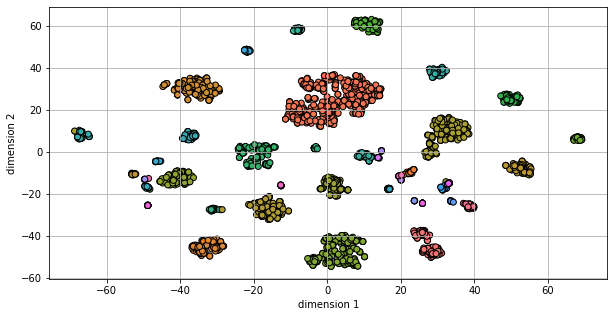

In [ ]:
tsne1 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(easy_embs)
draw_df = pd.DataFrame(tsne1, columns=['dimension 1', 'dimension 2'])
draw_df['label'] = easy_labels
draw_df['label'] = draw_df['label'].astype('str')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='dimension 1', y='dimension 2', hue='label', data=draw_df,
                edgecolor='black', linewidth=1, legend=False)
plt.grid()
pass

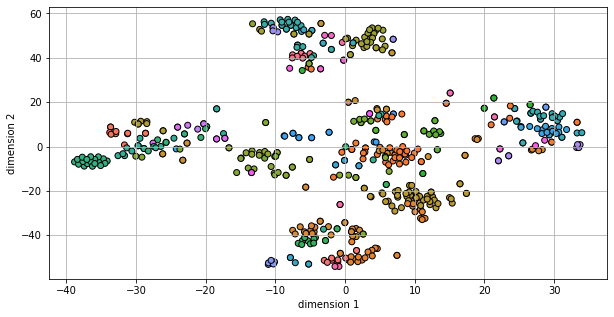

In [ ]:
tsne1 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(hard_embs)
draw_df = pd.DataFrame(tsne1, columns=['dimension 1', 'dimension 2'])
draw_df['label'] = hard_labels
draw_df['label'] = draw_df['label'].astype('str')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='dimension 1', y='dimension 2', hue='label', data=draw_df,
                edgecolor='black', linewidth=1, legend=False)
plt.grid()
pass

In [ ]:
# unique_labels = local_data_loader.dataset.tensors[3].unique()
# avg_easy_emb = hard_easy_embs[easy_ids].mean(axis=0)
# avg_hard_emb = hard_easy_embs[hard_ids].mean(axis=0)


label2easy_id = {}
for i, label in enumerate(easy_labels):
    if label not in label2easy_id:
        label2easy_id[label] = [easy_ids[i]]
    else:
        label2easy_id[label].append(easy_ids[i])

label2hard_id = {}
for i, label in enumerate(hard_labels):
    if label not in label2hard_id:
        label2hard_id[label] = [hard_ids[i]]
    else:
        label2hard_id[label].append(hard_ids[i])

CONFIG['label2hard_id'] = label2hard_id
CONFIG['label2easy_id'] = label2easy_id
CONFIG['easy_ids'] = easy_ids
CONFIG['hard_ids'] = hard_ids

len(label2easy_id), len(label2hard_id)

(42, 36)

###  GAN training



In [ ]:
from trainer import trainer, gan_trainer, gan_distil_trainer

trainer = imp.reload(trainer)
gan_trainer = imp.reload(gan_trainer)
gan_distil_trainer = imp.reload(gan_distil_trainer)
gc.collect()
torch.cuda.empty_cache()

In [ ]:
CONFIG['distil_gan'] = False
if CONFIG['distil_gan']:
    aversarial_trainer = gan_distil_trainer.GANDistilTrainer(config=CONFIG,
                                                            generator=generator, 
                                                            discriminator=discriminator, 
                                                            train_dataloader=labeled_dataloader,
                                                            train_tensor=labeled_dataloader.dataset.tensors[0],
                                                            valid_dataloader=test_dataloader,
                                                            device=device)
else:
    aversarial_trainer = gan_trainer.GANTrainer(config=CONFIG,
                                                generator=generator, 
                                                discriminator=discriminator,
                                                train_dataloader=train_dataloader,
                                                valid_dataloader=test_dataloader,
                                                device=device)

Trainable layers 203


In [ ]:
%%time
run = None
tags = None
run = neptune.init(project=secret['procject'], api_token=secret['token'], tags=tags) 
run['config'] = aversarial_trainer.config


for epoch_i in range(0, CONFIG['num_train_epochs']):
    print(f"======== Epoch {epoch_i + 1} / {CONFIG['num_train_epochs']} ========")
    tr_g_loss, tr_d_loss = aversarial_trainer.train_epoch(log_env=run)
    result = aversarial_trainer.validation(tr_d_loss, tr_g_loss, epoch_i=epoch_i)
    run['valid/discriminator_loss'].log(result['discriminator_loss'])
    run['valid/discriminator_accuracy'].log(result['discriminator_accuracy'])

_labels, _predicts = discriminator.predict(test_dataloader, device=device)
f1_macro = f1_score(_labels, _predicts, average='macro')
f1_micro = f1_score(_labels, _predicts, average='micro')
run['valid/f1_macro'].log(f1_macro)
run['valid/f1_micro'].log(f1_micro)
print(f'f1_macro {f1_macro:.3f}')
print(f'f1_micro {f1_micro:.3f}')
run.stop()

In [ ]:
# print(classification_report(_labels, _predicts, target_names=[label_list[_l] for _l in sorted(np.unique(_labels + _predicts))]))
print(classification_report(_labels, _predicts))

In [ ]:
# torch.save(discriminator, 'weights/discriminator.pt')

Post-anatysis 🧪
---

## Representations analysis

In [ ]:
transformer.eval()
transformer.to(device)
states_list = []
_labels = []
local_data_loader = data_loader.generate_data_loader(labeled_examples, 
                                                    labeled_masks, 
                                                    label_map=label2id, 
                                                    batch_size=64, 
                                                    tokenizer=tokenizer, 
                                                    max_seq_length=CONFIG['max_seq_length'],
                                                    do_shuffle=False, 
                                                    balance_label_examples=CONFIG['apply_balance'],
                                                    return_ids=False)
for batch in tqdm_notebook(local_data_loader):
    input_ids = batch[0].to(device)
    input_mask = batch[1].to(device)
    labels = batch[2]
    trf_output = transformer(input_ids, attention_mask=input_mask)
    hidden_states = trf_output.last_hidden_state[:, 0, :]
    states_list.append(hidden_states.cpu().detach().numpy())
    _labels.extend(labels.numpy())
_states = np.vstack(states_list)
emb_test_df = pd.DataFrame(_states)
emb_test_df['label'] = _labels
_states.shape

  0%|          | 0/35 [00:00<?, ?it/s]

(2180, 768)

In [ ]:
autoencoder.eval()
enc_states_list = []
for state in tqdm_notebook(_states):
    encoder_states = autoencoder.get_encoder(torch.from_numpy(state.reshape(1, -1)).to(device))
    enc_states_list.append(encoder_states.cpu().detach().numpy())
enc_states_list = np.vstack(enc_states_list)
enc_test_df = pd.DataFrame(enc_states_list)
enc_test_df['label'] = _labels

  0%|          | 0/2180 [00:00<?, ?it/s]

In [ ]:
label2stat = {}
for _label in enc_test_df.label.unique():
    _tmp = enc_test_df[enc_test_df.columns[:-1]][enc_test_df.label == _label].values
    _mean = _tmp.mean(axis=0)
    _cov = np.cov(_tmp.T)
    label2stat[_label] = {'mean': _mean, 'cov': _cov}

In [ ]:
from sklearn.manifold import TSNE

real_X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(_states)
real_draw_df = pd.DataFrame(real_X_embedded, columns=['dimension 1', 'dimension 2'])
real_draw_df['label'] = _labels
real_draw_df['label'] = real_draw_df['label'].apply(lambda x: f'{str(label_list[x])}')#.astype('str')

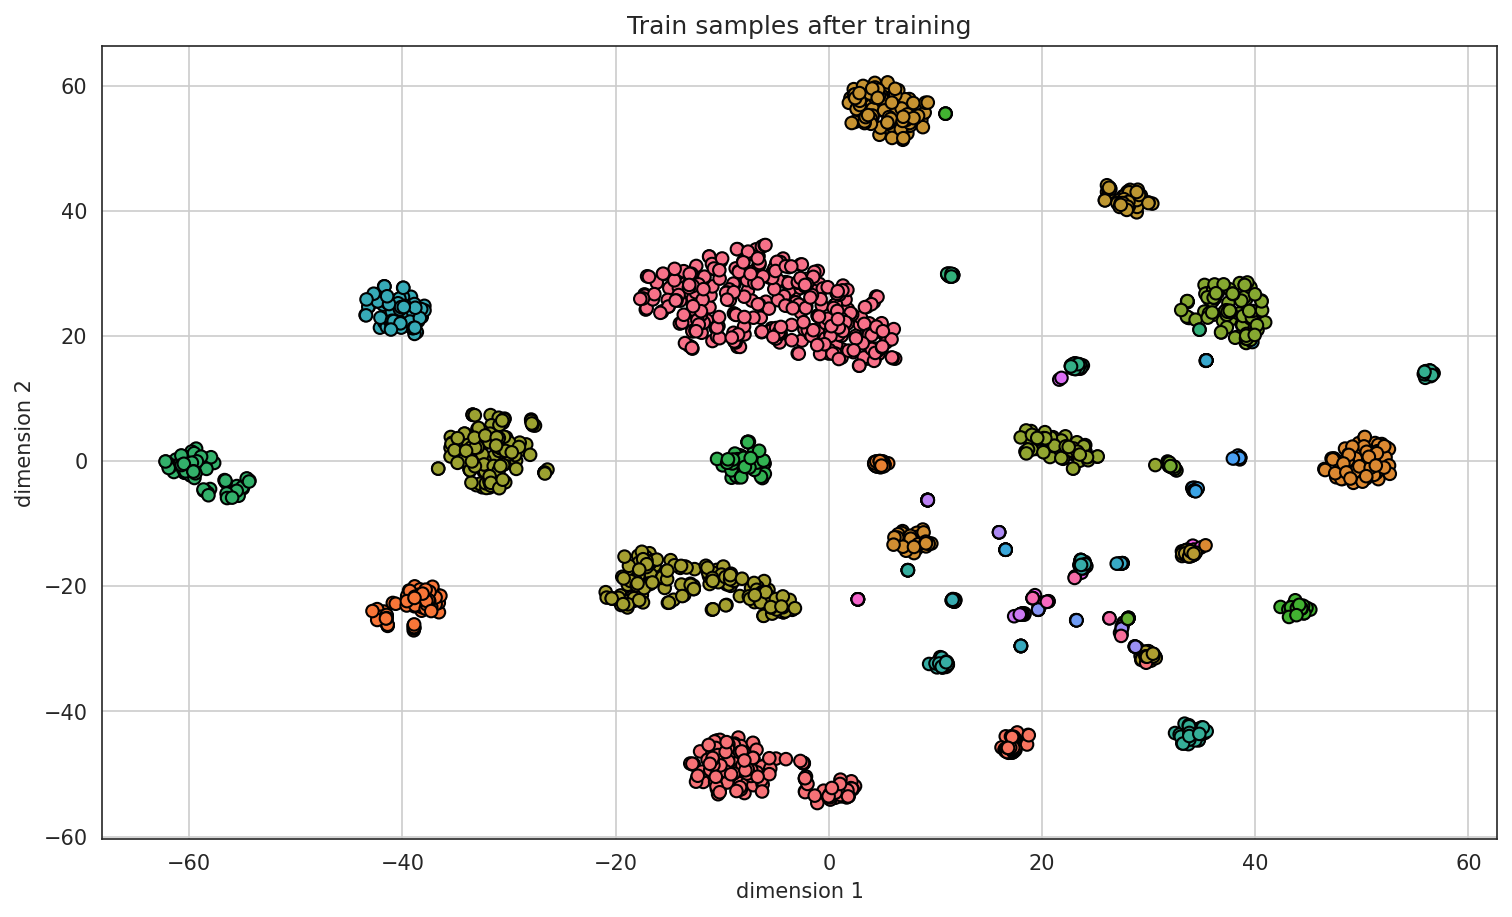

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,7))
sns.scatterplot(x='dimension 1', y='dimension 2', hue='label', 
                data=real_draw_df,
                edgecolor='black', linewidth=1, legend=None)
plt.grid()
plt.title('Train samples after training');

In [ ]:
N = 50000
generator.eval()
use_dist_params = False

K = 300
if use_dist_params:
    noises = []
    rand_labels = []
    for _ in tqdm_notebook(range(N // K)):
        _l = np.random.choice(list(label2stat.keys()))
        try:
            _noise = np.random.multivariate_normal(label2stat[_l]['mean'],  
                                                   np.diag(np.diag(label2stat[_l]['cov'])) * 100, size=K)
            noises.append(_noise)
            rand_labels.extend([_l] * K)
        except Exception as e:
            print(e)
            pass
    rand_labels = np.array(rand_labels)
    noise = np.vstack(noises).astype('float32')
else:
    noise = np.random.normal(0, 20, size=(N, 100)).astype('float32')

noise = torch.from_numpy(noise).to(device)
if CONFIG['conditional_generator']:
    if not use_dist_params:
        rand_labels = np.random.randint(1, CONFIG['num_labels'], 
                                        N, dtype='int')
    rand_labels = torch.from_numpy(rand_labels).to(device)
    generated_embs = generator(noise, rand_labels)
    rand_labels = rand_labels.cpu().numpy()
else:
    generated_embs = generator(noise)
generated_embs.shape
discriminator.eval()
_, logits, probs, _  = discriminator(external_states=generated_embs)

In [ ]:
probs = probs.cpu().detach().numpy()[:, 1: ]
np_probs = probs[:, :-1]
np_probs.shape

(50000, 50)

In [ ]:
np.unique(np.argmax(probs, axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 50])

In [ ]:
# pd.Series(np.argmax(probs, axis=1)).value_counts()

In [ ]:
if CONFIG['conditional_generator']:
    indx = np.argmax(probs, axis=1) == rand_labels
else:
    indx = np.argmax(probs, axis=1) != CONFIG['num_labels'] - 1
    # indx = np.argmax(probs, axis=1) != -1
cheat_embs = generated_embs[indx, :]
cheat_label = np.argmax(np_probs[indx], axis=1) + 1
cheat_embs.shape, len(cheat_label)

(torch.Size([1012, 768]), 1012)

In [ ]:
# pd.Series(cheat_label).value_counts()

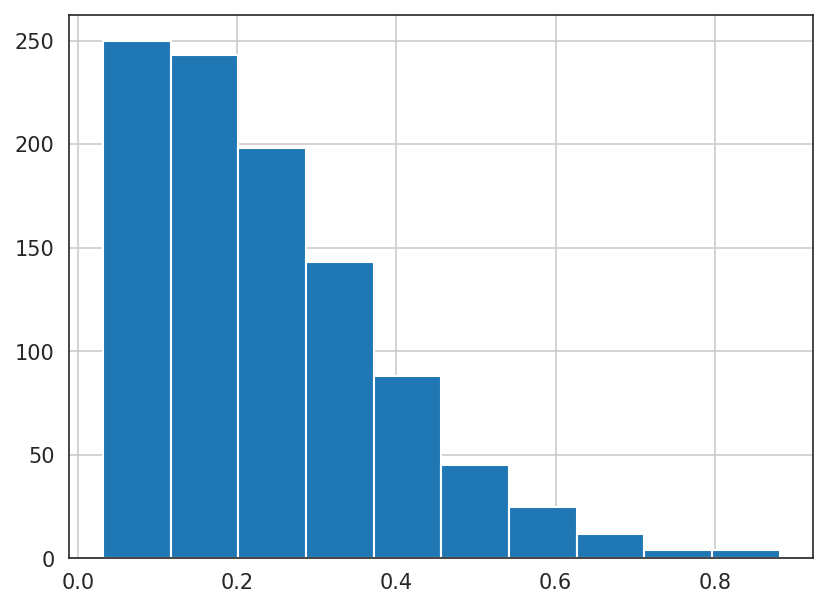

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np_probs[indx].max(axis=1))
plt.grid()
pass

In [ ]:
Q = 70
cut_of = np.percentile(np_probs[indx].max(axis=1), q=Q)
print(cut_of)
print(round(cheat_embs.shape[0] *(1 - (Q / 100))))
cut_of = 0.2

0.29722920060157776
304


In [ ]:
indx = np_probs[indx].max(axis=1) > cut_of
cheat_embs = cheat_embs[indx, :]
cheat_label = cheat_label[indx]

In [ ]:
print('Unique labels', len(np.unique(cheat_label)))
cheat_embs.shape, len(cheat_label)

Unique labels 1


(torch.Size([525, 768]), 525)

In [ ]:
from sklearn.manifold import TSNE

label2count = dict(labeled_df.label.value_counts())
generated_embs = cheat_embs.cpu().detach().numpy()
# generated_embs = generated_embs.cpu().detach().numpy()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(generated_embs)
draw_df = pd.DataFrame(X_embedded, columns=['dimension 1', 'dimension 2'])
draw_df['prdicted label'] = cheat_label # np.argmax(np_probs, 1)
# draw_df['prdicted label'] = np.argmax(np_probs, 1)
draw_df['prdicted label'] = draw_df['prdicted label'].apply(lambda x: f'{x} : {str(label_list[x])}  ({str(label2count[label_list[x]])})')
draw_df['prdicted label'] = draw_df['prdicted label'].astype('str')

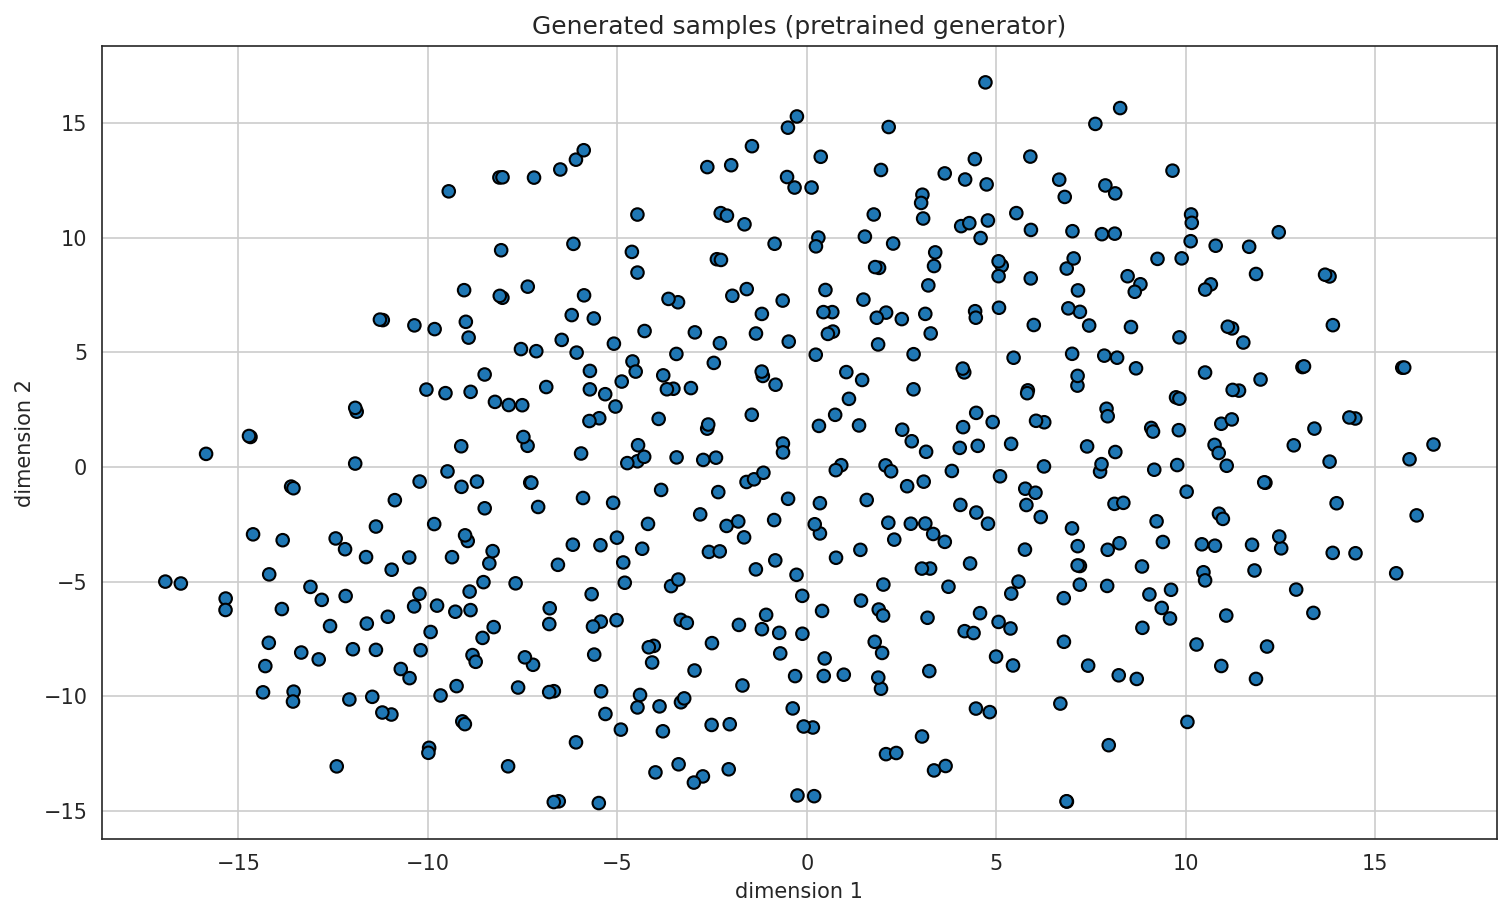

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,7))
sns.scatterplot(x='dimension 1', y='dimension 2', hue='prdicted label',
                edgecolor='black', linewidth=1,
                data=draw_df, 
                legend=None
                )
plt.grid()

plt.title('Generated samples (pretrained generator)');
pass

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.vstack([_states, generated_embs]))
_draw_df = pd.DataFrame(X_embedded, columns=['dimension 1', 'dimension 2'])
_draw_df['label'] = _labels + cheat_label.tolist()
_draw_df['label'] = _draw_df['label'].apply(lambda x: f'{str(label_list[x])}')#.astype('str')
_draw_df['is_generated'] = ['no'] * _states.shape[0] + ['yes'] * generated_embs.shape[0]

In [ ]:
# import importlib
# importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)
# matplotlib.rc_file_defaults()
# sns.reset_orig()

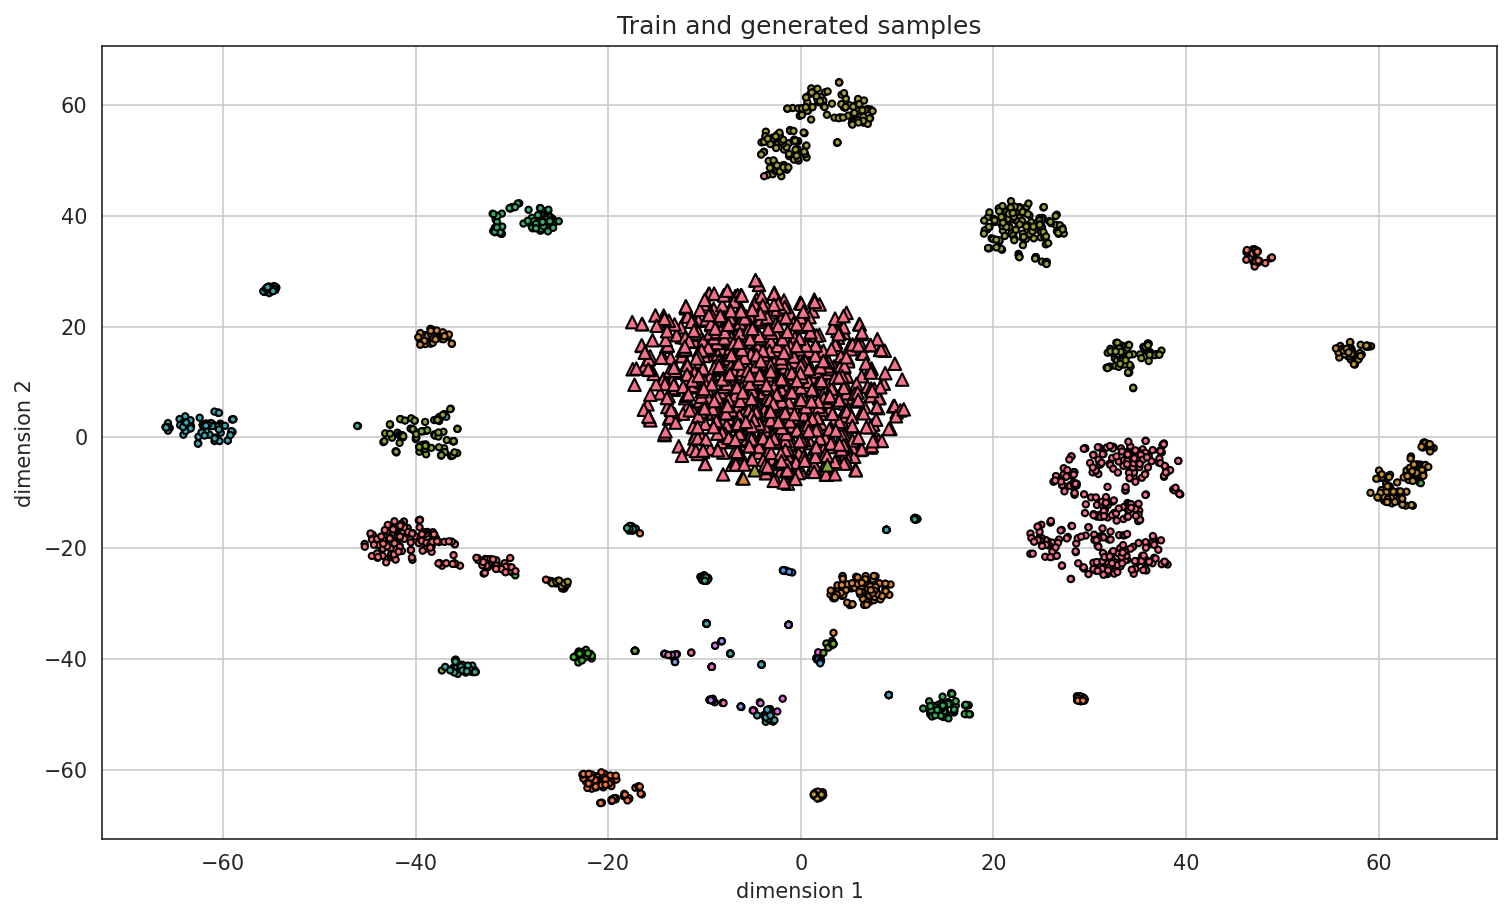

In [ ]:
mpl.rcParams['figure.dpi'] = 150
sns.set_style("white")
plt.figure(figsize=(12, 7))
markers = {"yes": "^", "no": "."}
_ = sns.scatterplot(x='dimension 1', y='dimension 2', 
                hue='label',  style='is_generated',
                data=_draw_df, markers=markers,
                 edgecolor='black',
                linewidth=1,
                legend=None
                )
plt.grid()
plt.title('Train and generated samples');

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=9, metric='cosine')
knn.fit(_states, _labels)
knn_predict = knn.predict(generated_embs)

In [ ]:
closest_match = np.argmax(cosine_similarity(generated_embs, _states), axis=1)
knn_df = pd.DataFrame(zip(cheat_label, knn_predict), columns=['cheat_label', 'knn_label'])
knn_df['closest_sample'] = labeled_df.iloc[closest_match]['text'].values
knn_df['closest_label'] = labeled_df.iloc[closest_match]['label'].values
knn_df['cheat_is_knn'] = knn_df.cheat_label == knn_df.knn_label

In [ ]:
knn_df['closest_sample'].value_counts()

How long was the longest hiccup attack ?                                                               20
What season begins with the vernal equinox ?                                                           18
What money was used by them ?                                                                          17
What Triple Crown-winning horse took the 1973 Belmont Stakes by 31 lengths ?                           14
What generation am I in ?                                                                              13
                                                                                                       ..
What does MSG stand for ?                                                                               1
How fast must a spacecraft travel to escape Earth 's gravity ?                                          1
What meter did Shakespeare use in writing : `` To be , or not to be , that is the question.. . '' ?     1
When did French revolutionaries storm the Bast

In [ ]:
knn_df.sample(6)

,cheat_label,knn_label,closest_sample,closest_label,cheat_is_knn
27,20,27,What currency is used in Australia ?,ENTY_currency,False
119,15,15,What money was used by them ?,ENTY_currency,True
571,5,4,What does hazmat stand for ?,DESC_def,False
35,8,8,What four-legged creature did a Cornell Univer...,ENTY_animal,True
96,14,7,"What 's the maximum length , in inches , of a ...",NUM_count,False
706,1,29,How long do you have to pay back debt after cl...,NUM_period,False


In [ ]:
print('Unique:', knn_df.cheat_label.nunique())
print('f1_macro:', round(f1_score(knn_df.cheat_label, knn_df.knn_label, average='macro'), 3))
print('f1_micro:', round(f1_score(knn_df.cheat_label, knn_df.knn_label, average='micro'), 3))
print()
np.around(knn_df['cheat_is_knn'].value_counts(normalize=True), 2)

Unique: 28
f1_macro: 0.16
f1_micro: 0.275



False    0.72
True     0.28
Name: cheat_is_knn, dtype: float64